In [23]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import GridSearchCV
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_score, davies_bouldin_score

# from sklearn.exceptions import ConvergenceWarning
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [24]:
pca_df = pd.read_csv('pca_df.csv')
df_wind_scaled = pd.read_csv('df_wind_scaled.csv')
df_subset = pd.read_csv('df_subset.csv')

In [25]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

# Model based clustering

## Gaussian Mixture

In [26]:
def clustering_score(estimator, X, silhouette_weight=0.5, davies_bouldin_weight=0.5):
    labels = estimator.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    final_score = silhouette_weight * silhouette + davies_bouldin_weight * davies_bouldin
    return final_score

In [5]:
# Define the parameter grid
param_grid = {
    'n_components': range(2,11),
}

gaussian_mix_clust = GaussianMixture(random_state=42)
                                     
# Initialize GridSearchCV
grid_search = GridSearchCV(gaussian_mix_clust, param_grid, scoring=clustering_score, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(df_wind_scaled)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[CV] END .....................................n_components=2; total time=  21.7s
[CV] END .....................................n_components=2; total time=  24.4s
[CV] END .....................................n_components=3; total time=  24.5s
[CV] END .....................................n_components=4; total time=  24.8s
[CV] END .....................................n_components=3; total time=  25.4s
[CV] END .....................................n_components=5; total time=  25.8s
[CV] END .....................................n_components=4; total time=  26.0s
[CV] END .....................................n_components=5; total time=  27.8s
[CV] END .....................................n_components=6; total time=  27.5s
[CV] END .....................................n_components=6; total time=  31.7s
[CV] END .....................................n_components=7; total time=  31.0s
[CV] END .....................................n_components=7; total time=  31.7s
[CV] END ...................

GridSearchCV(cv=2, estimator=GaussianMixture(random_state=42), n_jobs=-1,
             param_grid={'n_components': range(2, 11)},
             scoring=<function clustering_score at 0x7f707c2fe8e0>, verbose=2)

In [6]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Silhouette Score:", best_score)

Best Parameters: {'n_components': 6}
Best Silhouette Score: 2.272458704665367


In [27]:
gaussian_mix = GaussianMixture(n_components=6, random_state=42, verbose=1)
gaussian_mix.fit(df_wind_scaled)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged: True


GaussianMixture(n_components=6, random_state=42, verbose=1)

In [28]:
with open('results/model_based_opt/gaussian_mix.pickle', 'wb') as f:
    pickle.dump(gaussian_mix, f)

In [8]:
with open('results/model_based_opt/gaussian_mix.pickle', 'rb') as f:
    gaussian_mix = pickle.load(f)

In [29]:
labels = gaussian_mix.predict(df_wind_scaled)

In [30]:
len(np.unique(labels))

6

In [31]:
pca_df = pca_df.loc[:,:'PC2']

In [32]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

df_wind_scaled['cluster_label'] = labels
df_wind_scaled['asset_id'] = df_subset['asset_id']

In [33]:
df_wind_scaled.to_csv('results/model_based_opt/csv_labels_cut_raw/gaussian_mix.csv', index = False)

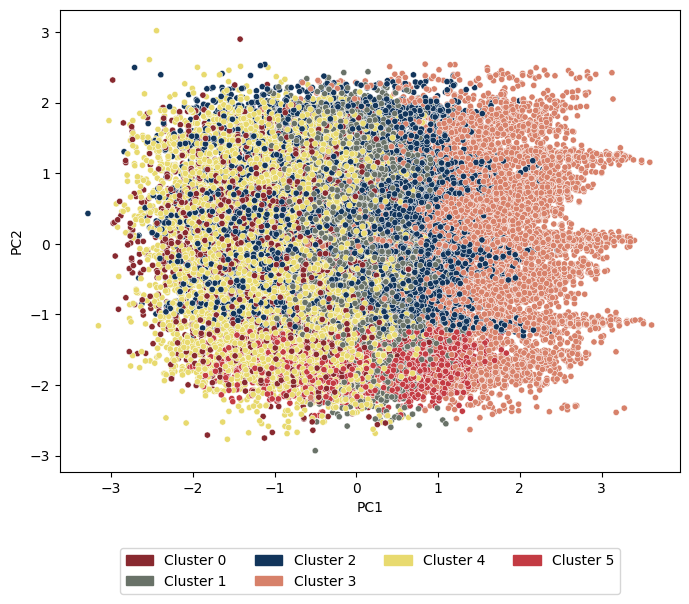

In [34]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [35]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns= 'cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.244564,0.905659,11,4
1,1.005866,-0.555092,11,4
2,1.056666,1.153545,11,4
3,-0.977673,-1.703177,11,4
4,-0.132186,-0.100377,11,4


In [36]:
len(most_frequent_clusters.unique())

3

In [37]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.244564,0.905659,11,4
1,1.005866,-0.555092,11,4
2,1.056666,1.153545,11,4
3,-0.977673,-1.703177,11,4
4,-0.132186,-0.100377,11,4


In [38]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.244564,0.905659,4
1,12,1.497088,0.674901,4
2,13,2.062604,1.346794,4
3,14,0.845746,-0.522152,4
4,15,0.399581,-2.079790,4
...,...,...,...,...
66,414,0.055038,-1.597480,4
67,415,-0.845582,-0.183552,4
68,510,1.066913,0.833683,2
69,511,-0.453293,-0.108517,2


In [39]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 2: [8, 9, 11, 12, 14, 15, 16, 17, 36, 37, 38, 39, 40, 41, 42, 43, 44, 53, 60, 68, 69, 70]
Cluster 3: [6]
Cluster 4: [0, 1, 2, 3, 4, 5, 7, 10, 13, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67]


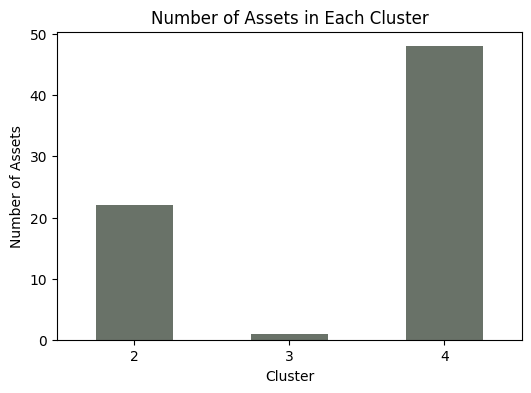

In [40]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [41]:
pca_df.to_csv('results/model_based_opt/labels_most_common/gaussian_mix.csv', index= False)

In [42]:
pca_df = pca_df.loc[:,:'PC2']

df_wind_scaled = df_wind_scaled.loc[:,:'2']

## Bayesian GMM

In [43]:
# Define the parameter grid
param_grid = {
    'n_components': range(2,11),
}

bgmm_clust = BayesianGaussianMixture(covariance_type='full', max_iter=1000, random_state=42, tol=1e-6)
                                     
# Initialize GridSearchCV
grid_search = GridSearchCV(bgmm_clust, param_grid, scoring=clustering_score, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(df_wind_scaled)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END .....................................n_components=2; total time=  21.0s
[CV] END .....................................n_components=2; total time=  21.1s
[CV] END .....................................n_components=3; total time=  23.9s
[CV] END .....................................n_components=3; total time=  24.6s


/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


[CV] END .....................................n_components=4; total time=  47.9s
[CV] END .....................................n_components=4; total time=  48.2s


/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


[CV] END .....................................n_components=5; total time= 1.3min


/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


[CV] END .....................................n_components=5; total time= 1.4min
[CV] END .....................................n_components=6; total time= 1.1min
[CV] END .....................................n_components=6; total time= 1.1min
[CV] END .....................................n_components=8; total time= 1.0min
[CV] END .....................................n_components=8; total time= 1.0min


/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


[CV] END .....................................n_components=7; total time= 2.0min
[CV] END .....................................n_components=7; total time= 1.9min
[CV] END .....................................n_components=9; total time= 1.2min
[CV] END .....................................n_components=9; total time= 1.2min
[CV] END ....................................n_components=10; total time= 1.3min
[CV] END ....................................n_components=10; total time= 1.3min


GridSearchCV(cv=2,
             estimator=BayesianGaussianMixture(max_iter=1000, random_state=42,
                                               tol=1e-06),
             n_jobs=-1, param_grid={'n_components': range(2, 11)},
             scoring=<function clustering_score at 0x7f707c897880>, verbose=2)

In [44]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Silhouette Score:", best_score)

Best Parameters: {'n_components': 5}
Best Silhouette Score: 2.209753105824267


In [45]:
# Fitting Bayesian Gaussian Mixture Model
bgmm = BayesianGaussianMixture(n_components=5, covariance_type='full', max_iter=1000, random_state=42, tol=1e-6)
bgmm.fit(df_wind_scaled)

# Predicting clusters for data points
labels = bgmm.predict(df_wind_scaled)

In [46]:
with open('results/model_based_opt/bgmm.pickle', 'wb') as f:
    pickle.dump(bgmm, f)

In [26]:
with open('results/model_based_opt/bgmm.pickle', 'rb') as f:
    bgmm = pickle.load(f)

labels = bgmm.predict(df_wind_scaled)

In [47]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

df_wind_scaled['cluster_label'] = labels
df_wind_scaled['asset_id'] = df_subset['asset_id']

In [48]:
df_wind_scaled.to_csv('results/model_based_opt/csv_labels_cut_raw/bgmm.csv', index = False)

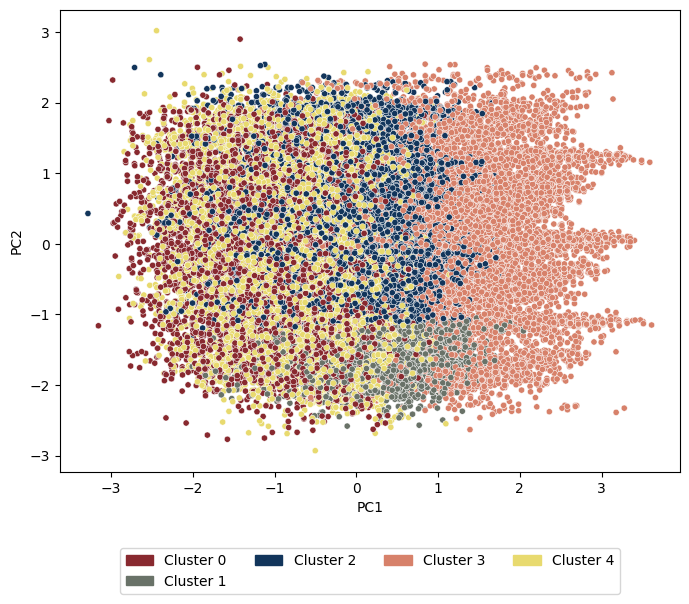

In [49]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Bayesian Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [50]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns = 'cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.244564,0.905659,11,4
1,1.005866,-0.555092,11,4
2,1.056666,1.153545,11,4
3,-0.977673,-1.703177,11,4
4,-0.132186,-0.100377,11,4


In [51]:
len(most_frequent_clusters.unique())

4

In [52]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.244564,0.905659,4
1,12,1.497088,0.674901,0
2,13,2.062604,1.346794,4
3,14,0.845746,-0.522152,4
4,15,0.399581,-2.079790,3
...,...,...,...,...
66,414,0.055038,-1.597480,4
67,415,-0.845582,-0.183552,0
68,510,1.066913,0.833683,2
69,511,-0.453293,-0.108517,2


In [53]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [1, 5, 18, 19, 20, 21, 22, 23, 32, 67]
Cluster 2: [8, 9, 12, 14, 15, 17, 26, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 53, 54, 58, 68, 69, 70]
Cluster 3: [4, 6, 16, 25, 46, 50, 51, 60]
Cluster 4: [0, 2, 3, 7, 10, 11, 13, 24, 27, 28, 29, 30, 31, 33, 34, 35, 48, 49, 52, 55, 56, 57, 59, 61, 62, 63, 64, 65, 66]


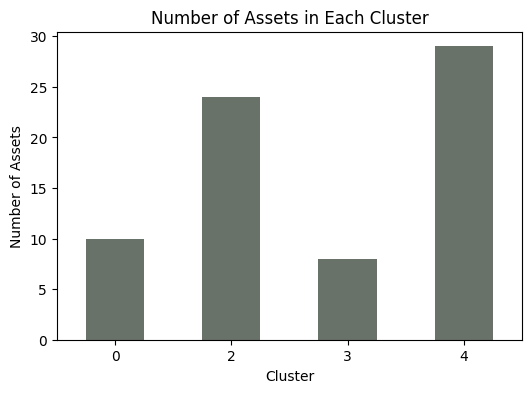

In [54]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [55]:
pca_df.to_csv('results/model_based_opt/labels_most_common/bgmm.csv', index= False)